In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
df = pd.read_csv("C:/Users/Pc_User/Desktop/H-Farm/predict_likelihood_v5.csv", index_col=0).drop(['labels', 'Score'],axis=1)
columns = list(df.columns.values)
df.reset_index(inplace=True)
customer_persona = pd.read_csv("C:/Users/Pc_User/Desktop/H-Farm/customer_persona.csv").drop('Unnamed: 0', axis=1)
customer_persona = customer_persona[customer_persona['Category'].isin(list(df.columns.values))]

### Compute the distance of each data point from the customer persona

In [2]:
customer_persona

,Category,Mean value among those buying insurance
1,Fruit,4.2
2,Vegetable,4.4
3,Red meat,3.0
4,Fish,3.0
5,Egg,2.6
6,Snacks,2.6
7,Junk,1.4
8,Ready to eat/drink,1.8
9,Alcohol,2.6
11,Contains plastic,2.6


In [3]:
customer_index = df['customer']
df.head(5)

,customer,Fruit,Vegetable,Red meat,Fish,Egg,Snacks,Junk,Ready to eat/drink,Alcohol,Contains plastic
0,77000001548,2.220152,2.774401,3.228952,1.715294,2.024853,1.880597,3.223240,2.962881,2.220152,2.638226
1,77000001680,2.662434,3.417868,2.951960,2.639690,1.884086,1.716192,3.211076,2.217409,2.109518,2.438544
2,77000002166,2.708316,3.054547,2.625417,2.379250,1.817820,1.904317,2.910788,2.578741,2.525019,2.947967
3,77000004744,2.384525,3.629949,3.110104,3.159294,1.454771,1.896563,3.063224,2.320064,3.018718,2.976957
4,77000005496,3.672307,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create a "Loss function" which calculates the sum for all categories of the squared difference of each value from the mean of customer persona

In [4]:
broadcast = pd.concat([customer_persona['Mean value among those buying insurance']] * len(df), axis=1).T.reset_index(drop=True)
broadcast.columns = columns

In [5]:
loss_per_customer = pd.concat([np.sum((df[columns] - broadcast)**2, axis=1), df['customer']], axis=1).set_index('customer')
loss_per_customer.columns = ['Loss']
loss_per_customer.head(20)

,Loss
customer,
77000001548,13.935832
77000001680,8.475344
77000002166,8.672407
77000004744,9.087001
77000005496,30.878460
77000013484,27.614853
77000016559,28.436362
77000018175,15.525187
77000019287,25.449900


C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


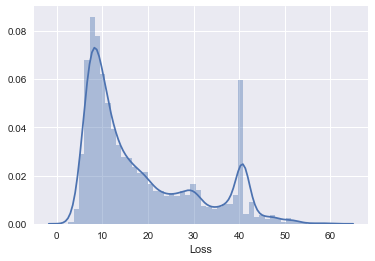

In [6]:
sns.distplot(loss_per_customer['Loss'])

In [7]:
loss_per_customer['Constant'] = '0'

In [8]:
from sklearn.cluster import KMeans
def K_means(data, number_of_clusters, one_dim=False):
    if one_dim:
        km = KMeans(n_clusters=number_of_clusters)
        labels = km.fit_predict(np.array(data).reshape(-1, 1))
        return np.squeeze(labels)
    else:
        km = KMeans(n_clusters=number_of_clusters)
        labels = km.fit_predict(np.array(data))
        data['labels'] = np.squeeze(labels)

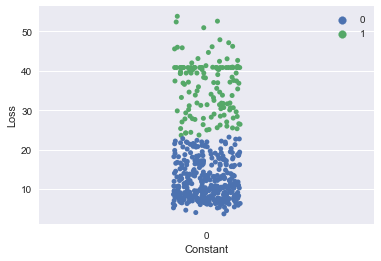

In [9]:
loss_per_customer['labels'] = K_means(loss_per_customer['Loss'], 2, True)
sample = loss_per_customer.sample(500)
sample['labels'].replace({1:'Offer them insurance', 0:'Don\'t offer them insurance'})
sns.stripplot(x=sample['Constant'], y=sample['Loss'] ,hue=sample['labels'],jitter=True, orient='v')
plt.legend()

In [10]:
healthy_categorization = pd.read_csv("C:/Users/Pc_User/Desktop/H-Farm/aliya_healthy.csv").set_index('customer')['Healthy']
assert len(healthy_categorization) == len(loss_per_customer)

In [11]:
loss_vs_healthy = pd.concat([healthy_categorization, loss_per_customer['Loss']], axis=1)
loss_vs_healthy.head(10)

,Healthy,Loss
customer,,
77000001548,0,13.935832
77000001680,0,8.475344
77000002166,0,8.672407
77000004744,0,9.087001
77000005496,0,30.878460
77000013484,0,27.614853
77000016559,0,28.436362
77000018175,0,15.525187
77000019287,0,25.449900


C:\Users\Pc_User\Anaconda3\envs\cs7643\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


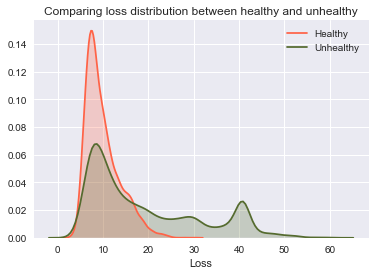

In [12]:
fig, ax = plt.subplots()
ax = sns.kdeplot(loss_vs_healthy.loc[loss_vs_healthy['Healthy'] == 1 , 'Loss'],
            color='tomato',
            shade=True,
            Label='Healthy')

ax = sns.kdeplot(loss_vs_healthy.loc[loss_vs_healthy['Healthy'] == 0 , 'Loss'],
            color='darkolivegreen',
            shade=True,
            Label='Unhealthy')

_ = ax.set(title="Comparing loss distribution between healthy and unhealthy",
          xlabel='Loss')
ax.grid(True)

## Final t-test

In [13]:
mean_loss_u = np.mean(loss_vs_healthy['Loss'][loss_vs_healthy['Healthy'] == 0])
print(mean_loss_u)

19.053378864594965


In [14]:
mean_loss_h = np.mean(loss_vs_healthy['Loss'][loss_vs_healthy['Healthy'] == 1])
print(mean_loss_h)

9.934024671324282


In [15]:
mean_diff = mean_loss_u - mean_loss_h

In [16]:
standard_error = np.sqrt(
    np.var(loss_vs_healthy['Loss'][loss_vs_healthy['Healthy'] == 1]) / np.sum(loss_vs_healthy['Healthy'] == 1) +  
    np.var(loss_vs_healthy['Loss'][loss_vs_healthy['Healthy'] == 0]) / np.sum(loss_vs_healthy['Healthy'] == 0))  


In [17]:
test_statistics = mean_diff / standard_error
alpha = 0.05
test_statistics

120.71983915810513

In [25]:
from scipy.stats import t
p_value = (1 - t.cdf(test_statistics, len(df) - 2)) * 2
print(p_value)

0.0
